## Ingestion of topo_vect feature in the FC and the LeapNet models

In this notebook, we will expose the different ways of ingesting topo_vect feature into the LeapNet model used by the LIPS framework. Note that we are using leapnet proxy methods to transform this feature. For more details about encoding options, please take a look at the [leapnet documentation](https://github.com/BDonnot/leap_net)
. There are three mains ingestion methods implemented in the new version of LIPS: 
- Legacy method: ingest topo_vect feature into the decoder part of the network alongside the line_status but separately. This method is proposed by the leapnet original package (see leapnet docs for more details) 
- Topo_vect concatenated with line status: Similar to the previsou method, but instead of ingesting line_status and topo_vect separately, we first concatenate them, then ingested them into the same feature (tau_concatenated). This method is typically used when we want to explore possible remedial solutions (aka remedial actions) like in the Benchmark2 use case.
- Topo_vect as main input method: The last method is to ingest the topo_vect feature as input of the encoder part of the network and the line_status input on the decoder part. This method is usually used when we are not primarily interested in remedial actions, but the feature (topological changes) can influence the state of the network, as in Benchmark1 use case

In what follows we will illustrate an example of use by method

In [23]:
import tensorflow as tf

import pathlib

from lips.benchmark.powergridBenchmark import PowerGridBenchmark
from lips.augmented_simulators.tensorflow_models import LeapNet
from lips.augmented_simulators.tensorflow_models.powergrid import TfResNetPowerGrid
from lips.dataset.scaler import StandardScaler
from lips.dataset.scaler.powergrid_scaler import PowerGridScaler

from lips.config import ConfigManager
from lips.utils import get_path

In [2]:
# indicate required paths
LIPS_PATH = pathlib.Path().resolve().parent # it is supposed that the notebook had run from getting_started folder
DATA_PATH = LIPS_PATH / "reference_data" / "powergrid" / "l2rpn_case14_sandbox"
BENCH_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "benchmarks" / "l2rpn_case14_sandbox.ini"
SIM_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "simulators"
BASELINES_PATH = LIPS_PATH / "trained_baselines" / "powergrid"
TRAINED_BASELINES_PATH = LIPS_PATH / "trained_baselines" / "powergrid"
EVALUATION_PATH = LIPS_PATH / "evaluation_results" / "PowerGrid"
LOG_PATH = LIPS_PATH / "lips_logs.log"

In [3]:
benchmark = PowerGridBenchmark(benchmark_name="Benchmark1",
                                benchmark_path=DATA_PATH,
                                load_data_set=True,
                                log_path=LOG_PATH,
                                config_path=BENCH_CONFIG_PATH,
                               )

In [4]:
# fetching kwargs_tau from the benchmark config
bench_config = ConfigManager(section_name="Benchmark1", path=BENCH_CONFIG_PATH)
topo_actions = bench_config.get_option("dataset_create_params")["reference_args"]["topo_actions"]

kwargs_tau = []
for el in topo_actions:
     kwargs_tau.append(el["set_bus"]["substations_id"][0])
kwargs_tau

[(4, (2, 1, 2, 1, 2)), (1, (1, 2, 1, 2, 2, 2)), (5, (1, 1, 2, 2, 1, 2, 2))]

### 1. Legacy Method
line_status and topo_vect as input on the decoder part of the network but ingested separately

In [5]:
# Init the leapnet model 
leap_net = LeapNet(name="tf_leapnet",                   
                   bench_config_path=BENCH_CONFIG_PATH,
                   bench_config_name="Benchmark1",
                   sim_config_path=SIM_CONFIG_PATH / "tf_leapnet.ini",
                   sim_config_name="DEFAULT", 
                   log_path=LOG_PATH,
                   
                   layer = "resnet",
                   sizes_enc=(),
                   sizes_main=(200, 200),
                   sizes_out=(),
                   scale_main_layer = 200,
                   scale_input_dec_layer = 200,
                   mult_by_zero_lines_pred = False,
                   
                   # transform topo_vect with given_list option, see leapnet docs for more explanation on this encoding
                   topo_vect_to_tau="given_list",
                   kwargs_tau = kwargs_tau,
                   
                   scaler = PowerGridScaler,
                   )

In [6]:
leap_net.train(train_dataset=benchmark.train_dataset,
                val_dataset=benchmark.val_dataset,
                batch_size = 128,
                epochs=1)

2022-08-05 14:26:47.815608: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-05 14:26:49.293328: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 40800 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:03:00.0, compute capability: 8.6
2022-08-05 14:26:49.293961: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46721 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:43:00.0, compute capability: 8.6
2022-08-05 14:26:49.294503: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 w

  32/1172 [..............................] - ETA: 5s - loss: 12.2251 - a_or_hat_loss: 6.6449 - a_ex_hat_loss: 5.5803 - a_or_hat_mae: 2.1313 - a_ex_hat_mae: 1.9385

2022-08-05 14:29:02.371982: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1172/1172 [==============================] - 8s 6ms/step - loss: 0.7623 - a_or_hat_loss: 0.3993 - a_ex_hat_loss: 0.3631 - a_or_hat_mae: 0.3215 - a_ex_hat_mae: 0.3156 - val_loss: 0.1036 - val_a_or_hat_loss: 0.0499 - val_a_ex_hat_loss: 0.0537 - val_a_or_hat_mae: 0.1544 - val_a_ex_hat_mae: 0.1596


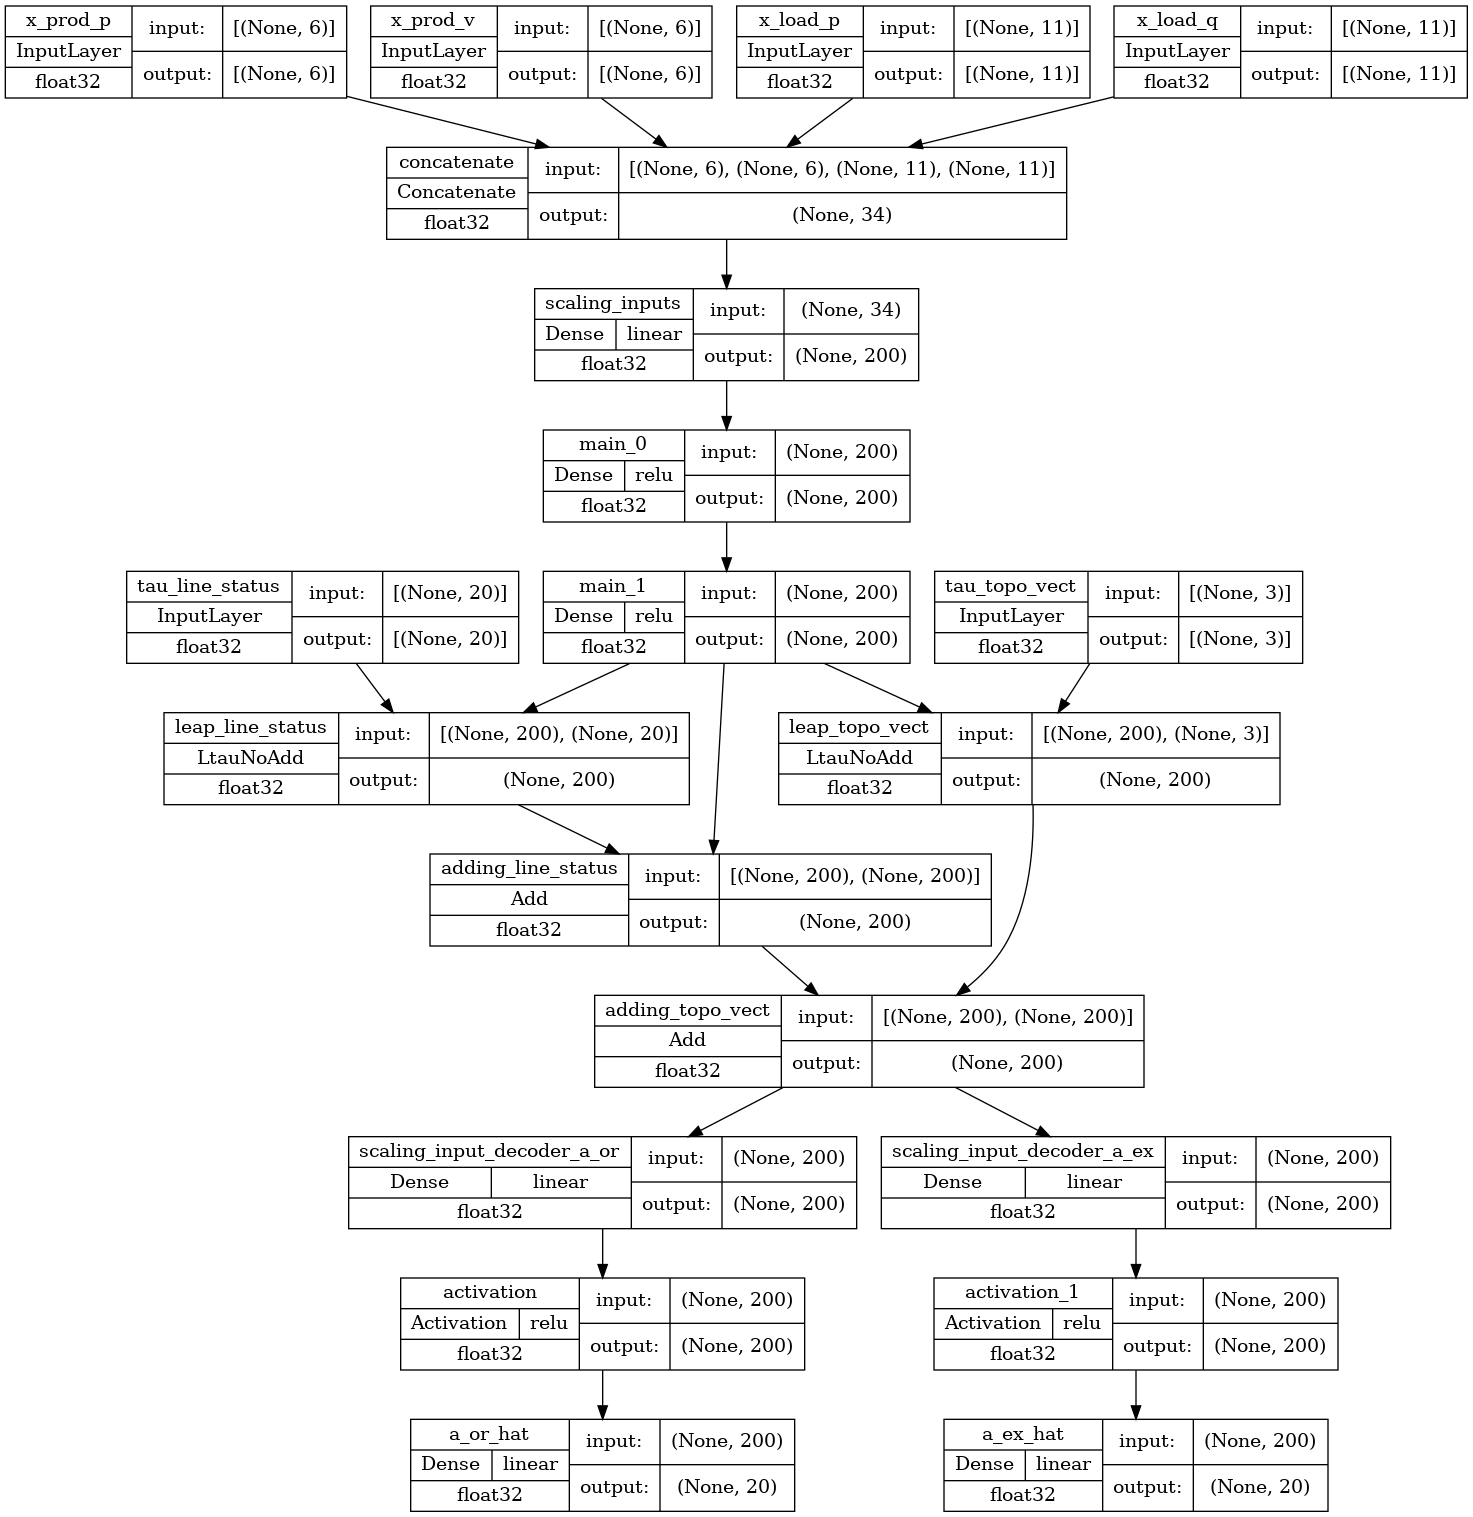

In [8]:
#Model architecture
tf.keras.utils.plot_model(
    leap_net._model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations= True)

As you notice in the architecture diagram, the two input layers tau_line_status and tau_topo_vect are ingested at the input of the decoder part (in the middle of the network)

### 2. Topo_vect concatenated with line status

To concatenate the two tau features line_status and topo_vect into a single feature you just need to pass the arguement concatenate_tau=True to the Leapnet signature as shown below : 

In [9]:
benchmark = PowerGridBenchmark(benchmark_name="Benchmark1",
                                benchmark_path=DATA_PATH,
                                load_data_set=True,
                                log_path=LOG_PATH,
                                config_path=BENCH_CONFIG_PATH,
                               )

In [10]:
# Init the leapnet model 
leap_net = LeapNet(name="tf_leapnet",                   
                   bench_config_path=BENCH_CONFIG_PATH,
                   bench_config_name="Benchmark1",
                   sim_config_path=SIM_CONFIG_PATH / "tf_leapnet.ini",
                   sim_config_name="DEFAULT", 
                   log_path=LOG_PATH,
                   
                   layer = "resnet",
                   sizes_enc=(),
                   sizes_main=(200, 200),
                   sizes_out=(),
                   scale_main_layer = 200,
                   scale_input_dec_layer = 200,
                   mult_by_zero_lines_pred = False,
                   
                   # transform topo_vect with given_list option, see leapnet docs for more explanation on this encoding
                   topo_vect_to_tau="given_list",
                   kwargs_tau = kwargs_tau,
                   concatenate_tau=True,
                   
                   scaler = PowerGridScaler,
                   )

/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/leap_net/proxy/proxyLeapNet.py:147: UserWarning: We strongly recommend you to get the "line_status" as an input vector
  warnings.warn("We strongly recommend you to get the \"line_status\" as an input vector")


You can ignore the warning. We already pass the line_status vector concatenated with topo_vect under the name of tau_concatenated

In [11]:
leap_net.train(train_dataset=benchmark.train_dataset,
                val_dataset=benchmark.val_dataset,
                batch_size = 128,
                epochs=1)

391/391 [==============================] - 3s 7ms/step - loss: 1.7161 - a_or_hat_loss: 0.8276 - a_ex_hat_loss: 0.8885 - a_or_hat_mae: 0.5574 - a_ex_hat_mae: 0.5734 - val_loss: 0.2948 - val_a_or_hat_loss: 0.1509 - val_a_ex_hat_loss: 0.1438 - val_a_or_hat_mae: 0.2605 - val_a_ex_hat_mae: 0.2544


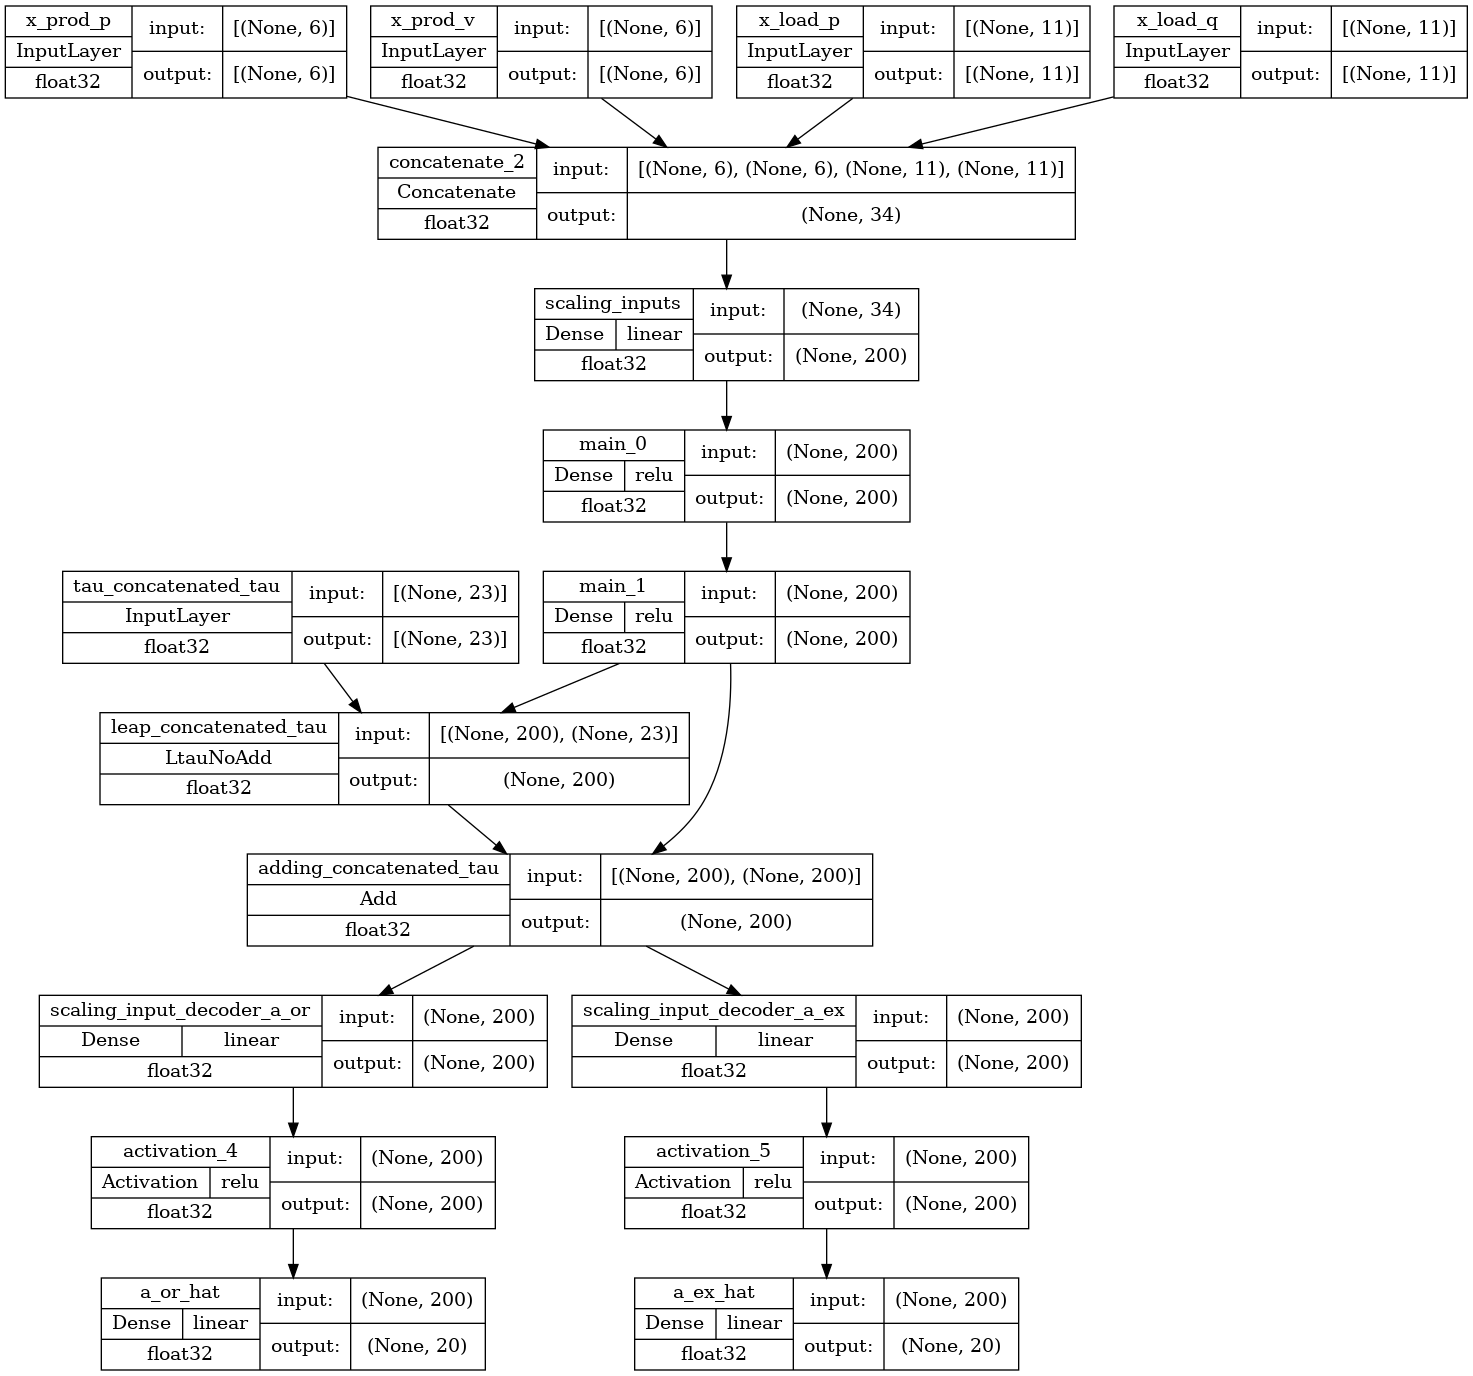

In [18]:
#Model architecture
tf.keras.utils.plot_model(
    leap_net._model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations= True)

You can notice that we have a new input feature called concatenated_tau, this vector (lenght == 23) is composed of line_status vector (length==20) and topo vector vector (length==3)

### 3. Topo_vect as main input

To pass the topo_vect feature as a main input, you need just to define it in the attr_x which can be found in the configuration file of the benchmark. This is what the configuration file will look like :

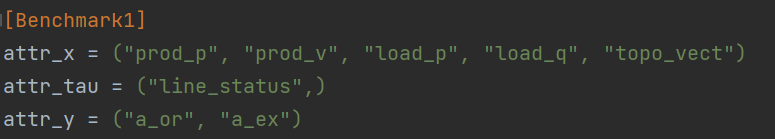

In [17]:
benchmark = PowerGridBenchmark(benchmark_name="Benchmark1",
                                benchmark_path=DATA_PATH,
                                load_data_set=True,
                                log_path=LOG_PATH,
                                config_path=BENCH_CONFIG_PATH,
                               )

In [18]:
# Init the leapnet model 
leap_net = LeapNet(name="tf_leapnet",                   
                   bench_config_path=BENCH_CONFIG_PATH,
                   bench_config_name="Benchmark1",
                   sim_config_path=SIM_CONFIG_PATH / "tf_leapnet.ini",
                   sim_config_name="DEFAULT", 
                   log_path=LOG_PATH,
                   
                   layer = "resnet",
                   sizes_enc=(),
                   sizes_main=(200, 200),
                   sizes_out=(),
                   scale_main_layer = 200,
                   scale_input_dec_layer = 200,
                   mult_by_zero_lines_pred = False,
                   
                   # transform topo_vect with given_list option, see leapnet docs for more explanation on this encoding
                   topo_vect_to_tau="given_list",
                   kwargs_tau = kwargs_tau,
                   
                   scaler = PowerGridScaler,
                   )

In [19]:
leap_net.train(train_dataset=benchmark.train_dataset,
                val_dataset=benchmark.val_dataset,
                batch_size = 128,
                epochs=1)

391/391 [==============================] - 3s 7ms/step - loss: 1.6715 - a_or_hat_loss: 0.8039 - a_ex_hat_loss: 0.8676 - a_or_hat_mae: 0.5526 - a_ex_hat_mae: 0.5708 - val_loss: 0.3125 - val_a_or_hat_loss: 0.1560 - val_a_ex_hat_loss: 0.1565 - val_a_or_hat_mae: 0.2679 - val_a_ex_hat_mae: 0.2670


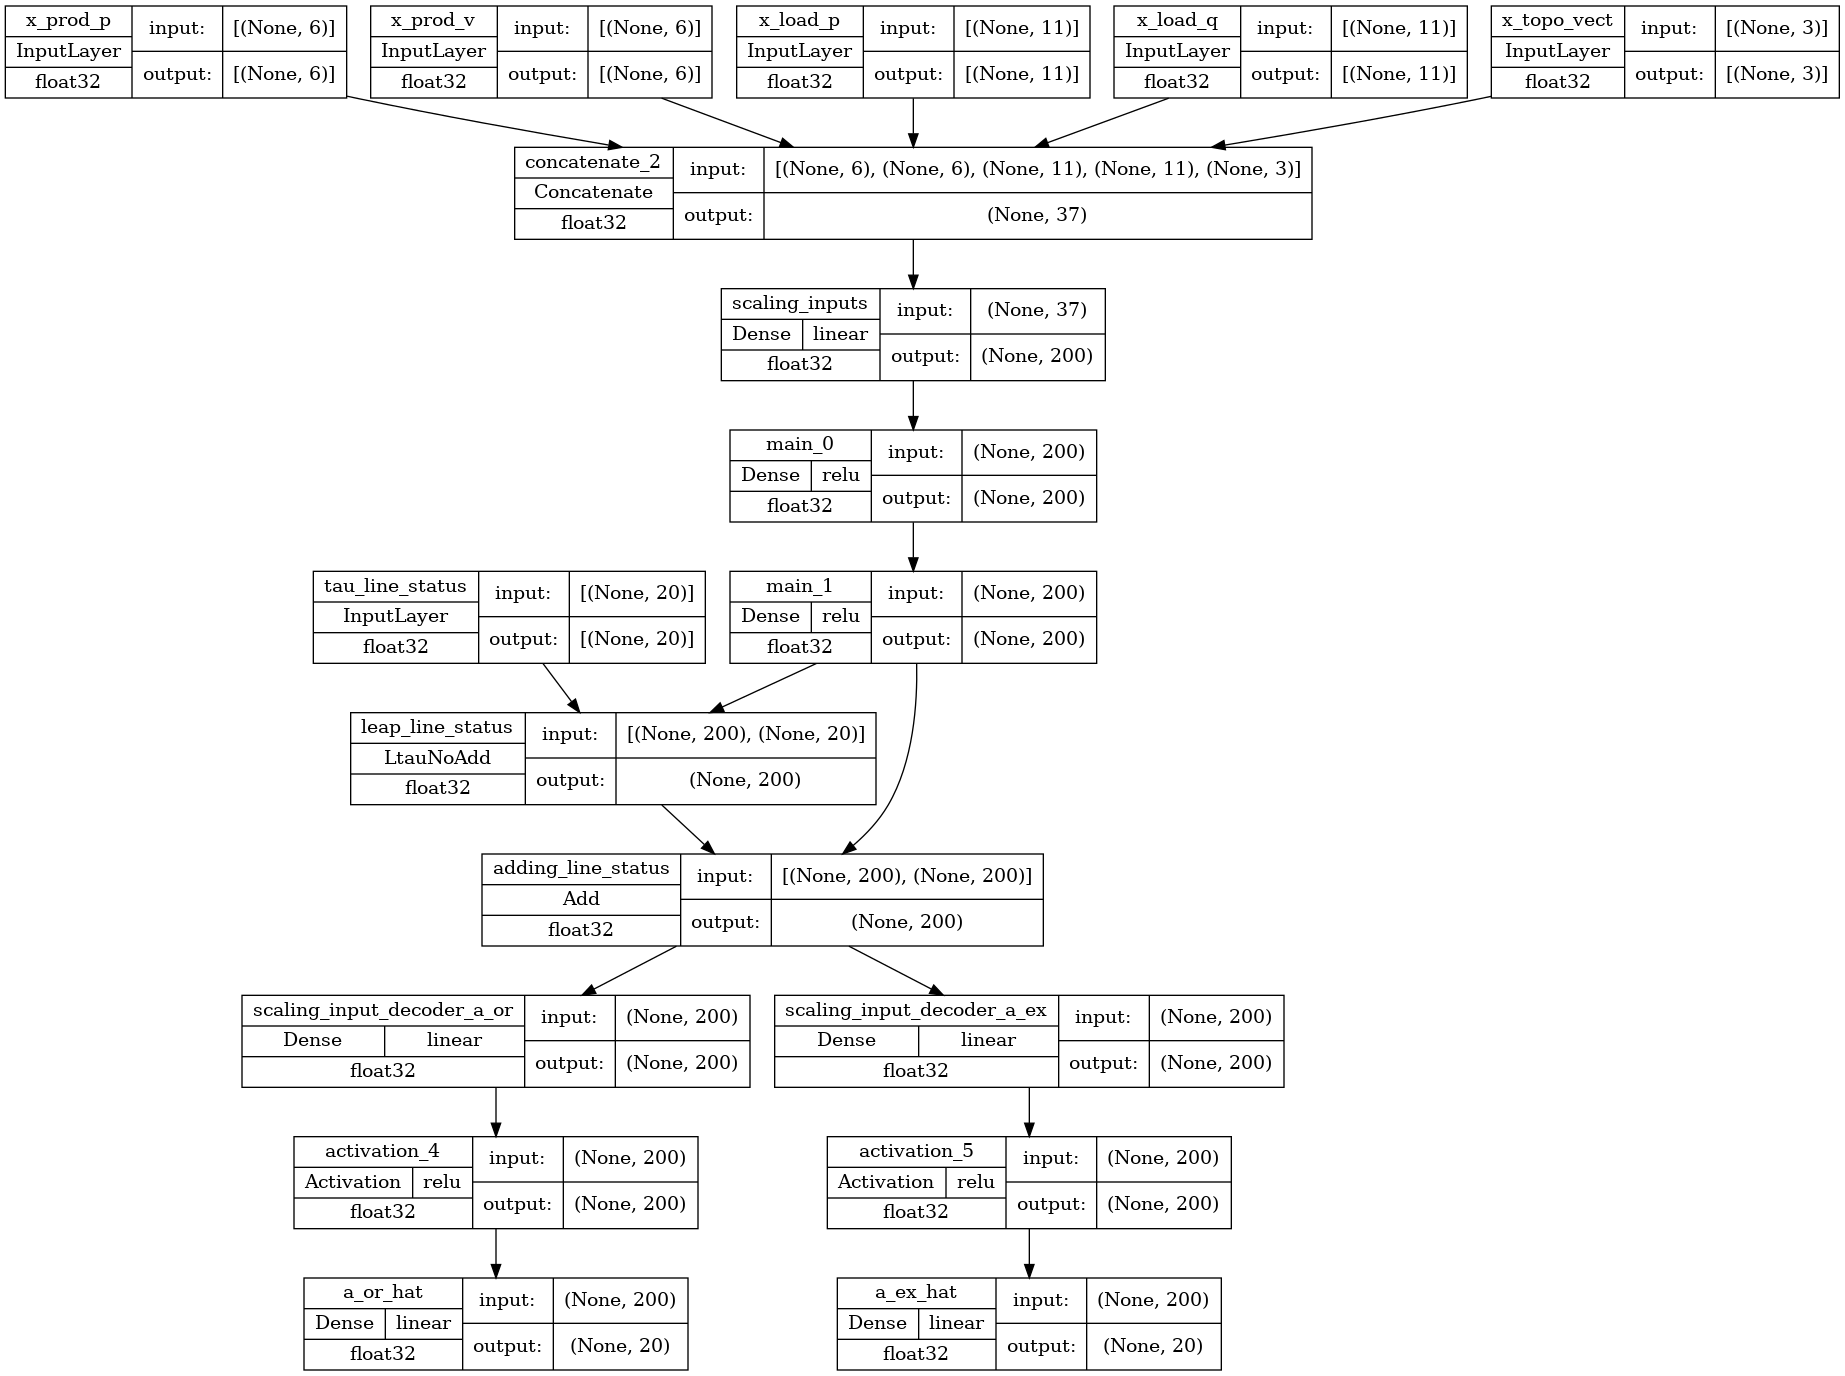

In [20]:
#Model architecture
tf.keras.utils.plot_model(
    leap_net._model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations= True)

## tau transformation in the ResNet model 

In the new version of LIPS, we use the Leapnet proxy to encode the topo_vect feature. To do this, we pass the same argument as in LeapNet model and as demonstrated in the example below:

In [24]:
benchmark = PowerGridBenchmark(benchmark_name="Benchmark1",
                                benchmark_path=DATA_PATH,
                                load_data_set=True,
                                log_path=LOG_PATH,
                                config_path=BENCH_CONFIG_PATH,
                               )

In [26]:
tf_resnet = TfResNetPowerGrid(name="tf_resnet",
                         bench_config_path=BENCH_CONFIG_PATH,
                         bench_config_name="Benchmark1",
                         sim_config_path=SIM_CONFIG_PATH / "tf_leapnet.ini",
                         sim_config_name="DEFAULT", 
                         log_path=LOG_PATH,
                         
                         layers = [200, 200, 200],            
                         layer = "resnet",
                         scale_input_layer = True,
                         
                         # transform topo_vect with given_list option, see leapnet docs for more explanation on this encoding
                         topo_vect_to_tau="given_list",
                         kwargs_tau = kwargs_tau,
                                                  
                         scaler = StandardScaler,
                                     )

In [27]:
tf_resnet.train(train_dataset=benchmark.train_dataset,
            val_dataset=benchmark.val_dataset,
            batch_size = 128,
            epochs= 1)

391/391 [==============================] - 2s 5ms/step - loss: 0.2128 - mae: 0.2973 - val_loss: 0.0551 - val_mae: 0.1706


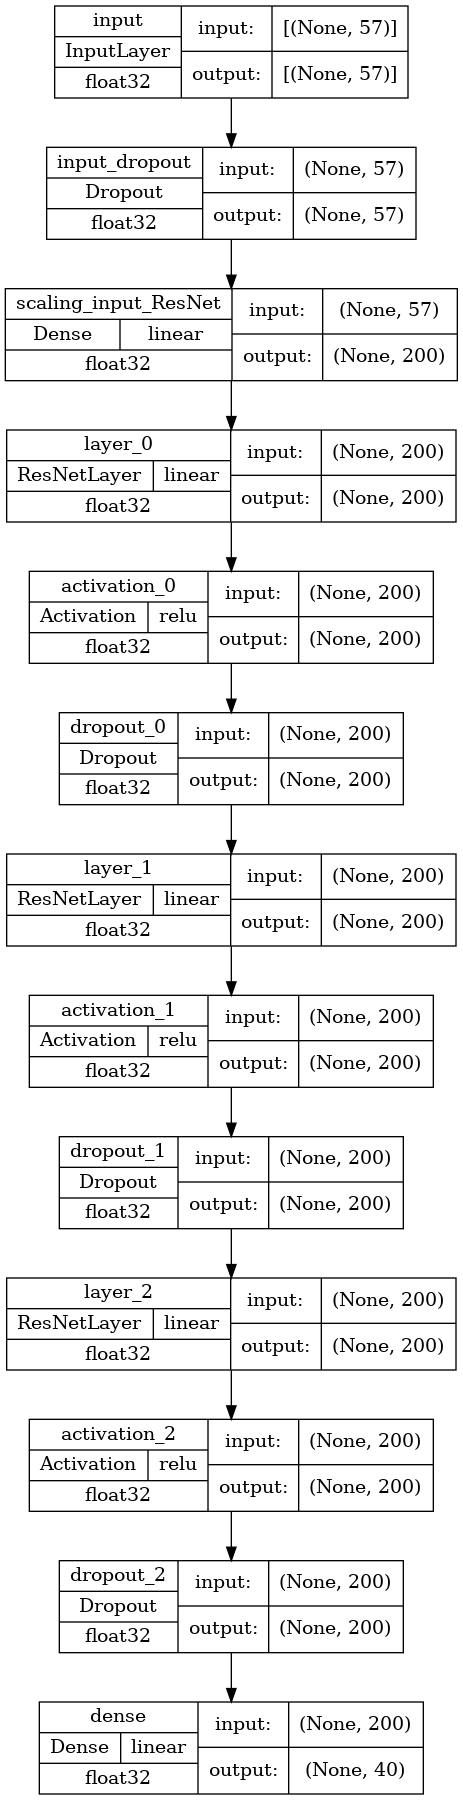

In [28]:
tf.keras.utils.plot_model(
    tf_resnet._model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations= True)